<a href="https://colab.research.google.com/github/greenixproject/machine-learning/blob/main/Vehicle_Greenix/new_model/Greenix_vehicle_emissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.13.0rc1
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.13.0rc1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (524.1 MB)
  Using cached keras-2.13.1rc0-py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
  Using cached tensorflow_estimator-2.13.0rc0-py2.py3-none-any.whl (440 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.3:
      Successfully uninstalled tensorboard-2.12.3
  Attempting uninstall: tensorflow
    Found existing installatio

In [2]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf
import tensorflowjs as tfjs
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

print(tf.__version__)

2.12.0


## Vehicle Datast

The dataset is available from the [Greenix Machine Learning Repository](https://docs.google.com/spreadsheets/d/1IJYOS6bOAGhYBRam_2W1_GvcVVHMdZR1/edit?usp=sharing&ouid=111311287901752825886&rtpof=true&sd=true).


### Get the data
First download and import the dataset using pandas:

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Menentukan path file CSV yang telah diunggah
url = '/content/drive/MyDrive/Vehicle_Greenix/Dataset/dataset_vehicle.csv'
column_names = ['no',	'car_class',	'fuel_type_car',	'emissions_factor_car',	'distanced_car',	'emissions_car',	'motor_class',	'motor_subclass',	'fuel_type_motor',	'emission_factor_motor',	'distanced_motor',	'emissions_motor',	'bus_class',	'fuel_type_bus',	'emission_factor_bus',	'distanced_bus',	'emissions_bus',	'total_emissions']

# Membaca file CSV ke DataFrame
df = pd.read_csv(url)

# Menampilkan beberapa baris pertama DataFrame
print(df.head())


   no car_class fuel_type_car  emissions_factor_car  distanced_car  \
0   1   Compact        Diesel                 0.142             13   
1   2   Compact        Diesel                 0.142             44   
2   3   Compact        Diesel                 0.142             21   
3   4   Compact        Diesel                 0.142             57   
4   5   Compact        Diesel                 0.142             85   

   emissions_car motor_class motor_subclass fuel_type_motor  \
0          1.846      110_CC        Injeksi          Petrol   
1          6.248      110_CC        Injeksi          Petrol   
2          2.982      110_CC        Injeksi          Petrol   
3          8.094      110_CC        Injeksi          Petrol   
4         12.070      110_CC        Injeksi          Petrol   

   emission_factor_motor  distanced_motor  emissions_motor bus_class  \
0                  0.103               43            4.429     Large   
1                  0.103               64            6.5

### Clean the data

The dataset contains a few unknown values:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   no                     651 non-null    int64  
 1   car_class              651 non-null    object 
 2   fuel_type_car          651 non-null    object 
 3   emissions_factor_car   651 non-null    float64
 4   distanced_car          651 non-null    int64  
 5   emissions_car          651 non-null    float64
 6   motor_class            651 non-null    object 
 7   motor_subclass         651 non-null    object 
 8   fuel_type_motor        651 non-null    object 
 9   emission_factor_motor  651 non-null    float64
 10  distanced_motor        651 non-null    int64  
 11  emissions_motor        651 non-null    float64
 12  bus_class              651 non-null    object 
 13  fuel_type_bus          651 non-null    object 
 14  emission_factor_bus    651 non-null    float64
 15  distan

In [8]:
# cek data duplikat
df.duplicated().sum()

0

In [9]:
# Membersihkan data yang tidak lengkap (Jika ada)
df = df.dropna(axis=0)

In [10]:
# Menghapus Kolom yang tidak diperlukan
df = df.drop(['no',	'fuel_type_car',	'emissions_factor_car',	'motor_subclass',	'fuel_type_motor',	'emission_factor_motor',	'fuel_type_bus',	'emission_factor_bus'], axis=1)

df.head()

,car_class,distanced_car,emissions_car,motor_class,distanced_motor,emissions_motor,bus_class,distanced_bus,emissions_bus,total_emissions
0,Compact,13,1.846,110_CC,43,4.429,Large,37,48.1,54.375
1,Compact,44,6.248,110_CC,64,6.592,Large,90,117.0,129.840
2,Compact,21,2.982,110_CC,9,0.927,Large,91,118.3,122.209
3,Compact,57,8.094,110_CC,38,3.914,Large,48,62.4,74.408
4,Compact,85,12.070,110_CC,74,7.622,Large,67,87.1,106.792


In [11]:
# Melihat jumlah baris dan kolom
df.shape

(651, 10)

In [12]:
# Melihat info statistik data
df.describe()

,distanced_car,emissions_car,distanced_motor,emissions_motor,distanced_bus,emissions_bus,total_emissions
count,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000
mean,51.397849,7.298495,51.299539,5.283853,50.983103,66.278034,78.860381
std,28.930153,4.108082,28.981442,2.985089,27.295162,35.483711,35.833703
min,1.000000,0.142000,1.000000,0.103000,5.000000,6.500000,8.538000
25%,27.000000,3.834000,24.000000,2.472000,28.000000,36.400000,48.085500
50%,51.000000,7.242000,52.000000,5.356000,50.000000,65.000000,76.698000
75%,77.000000,10.934000,76.000000,7.828000,74.500000,96.850000,108.428500
max,100.000000,14.200000,100.000000,10.300000,100.000000,130.000000,151.499000


In [13]:
# Melihat tipe data
print(df.dtypes)

car_class           object
distanced_car        int64
emissions_car      float64
motor_class         object
distanced_motor      int64
emissions_motor    float64
bus_class           object
distanced_bus        int64
emissions_bus      float64
total_emissions    float64
dtype: object


In [14]:
# melihat missing values
df[df==0].count()

car_class          0
distanced_car      0
emissions_car      0
motor_class        0
distanced_motor    0
emissions_motor    0
bus_class          0
distanced_bus      0
emissions_bus      0
total_emissions    0
dtype: int64

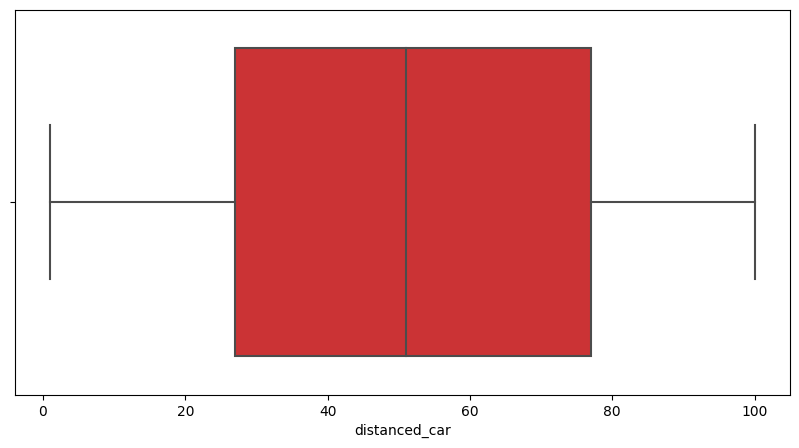

<Figure size 640x480 with 0 Axes>

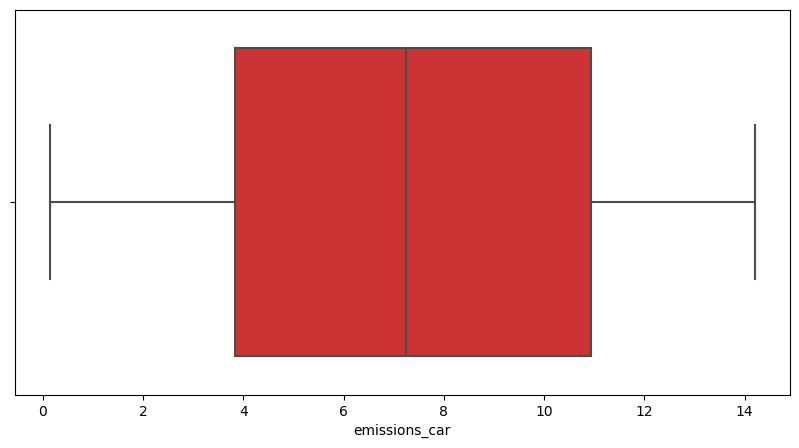

<Figure size 640x480 with 0 Axes>

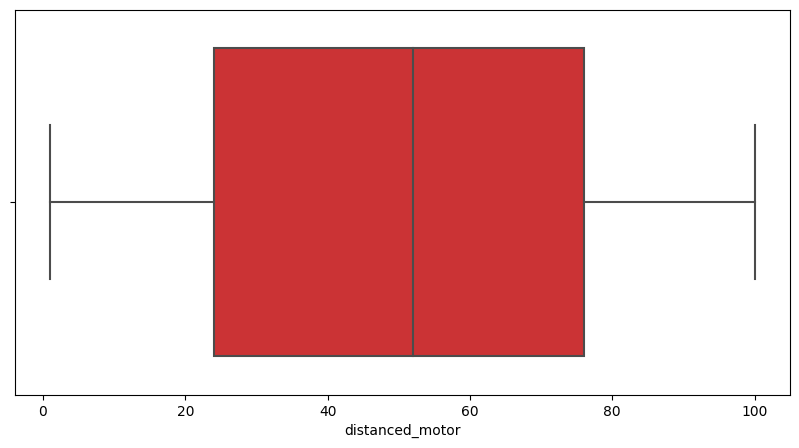

<Figure size 640x480 with 0 Axes>

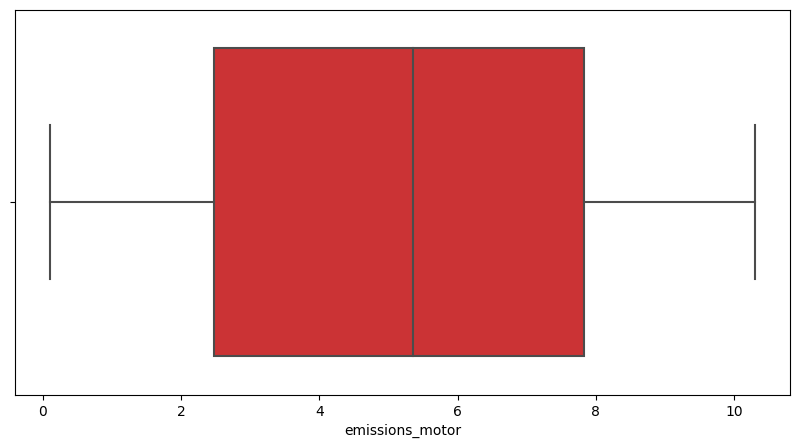

<Figure size 640x480 with 0 Axes>

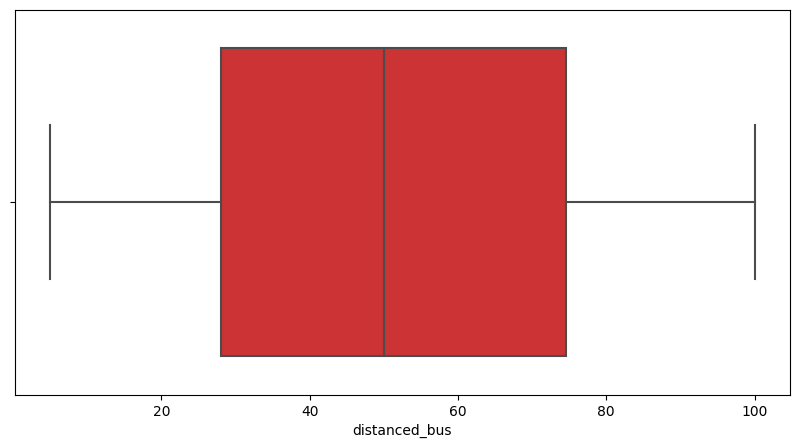

<Figure size 640x480 with 0 Axes>

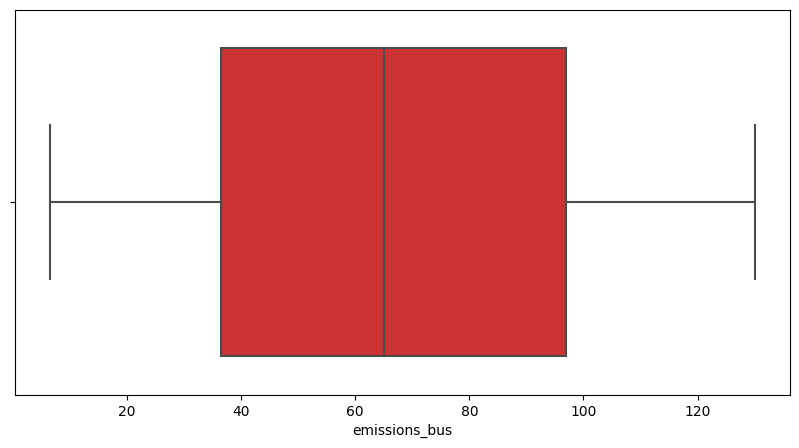

<Figure size 640x480 with 0 Axes>

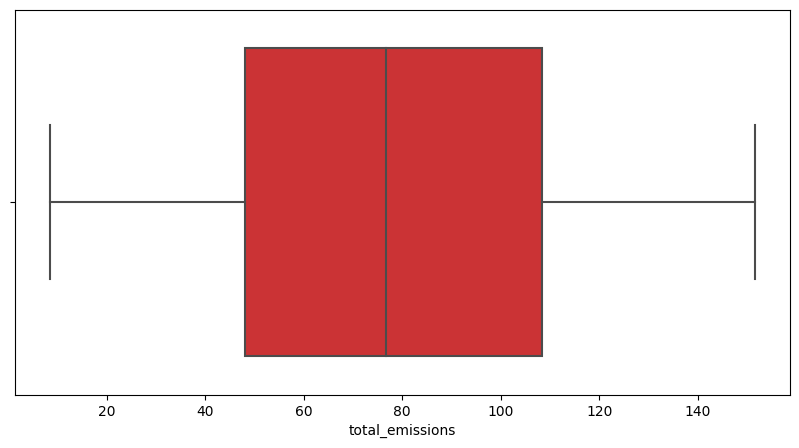

<Figure size 640x480 with 0 Axes>

In [15]:
#Cek data outlier
num_feat = ['distanced_car',	'emissions_car',	'distanced_motor',	'emissions_motor',	'distanced_bus',	'emissions_bus',	'total_emissions']
cat_feat = ['car_class', 'motor_class', 'bus_class']

for num in num_feat :
  plt.figure(figsize = (10,5))
  sns.boxplot(data = df, x = num, palette = 'Set1')
  plt.figure()

**Unvariate Analysis**



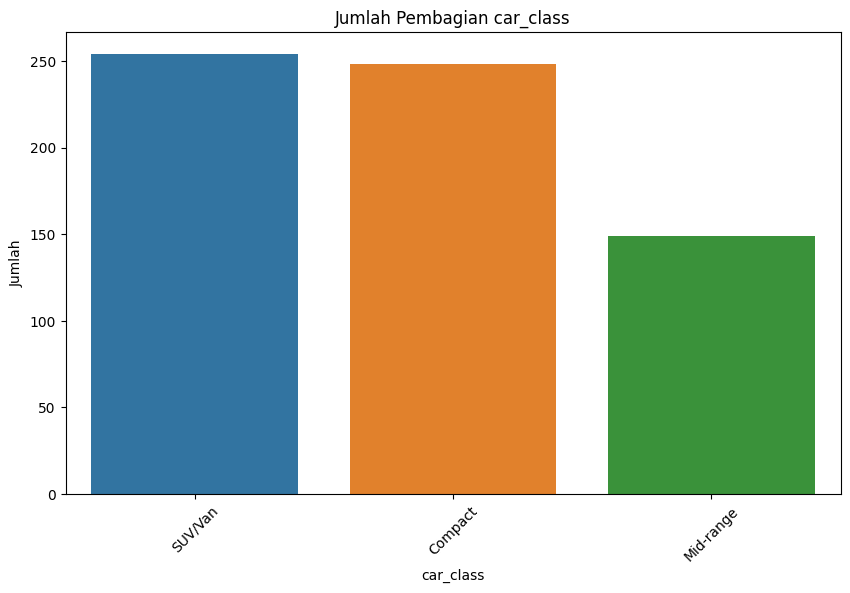

In [16]:
# Specify the string (categorical) column
column_name = 'car_class'  # Replace with the actual column name

# Calculate value counts
value_counts = df[column_name].value_counts()

# Create a bar plot of the value counts
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title('Jumlah Pembagian ' + column_name)
plt.xlabel(column_name)
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.show()

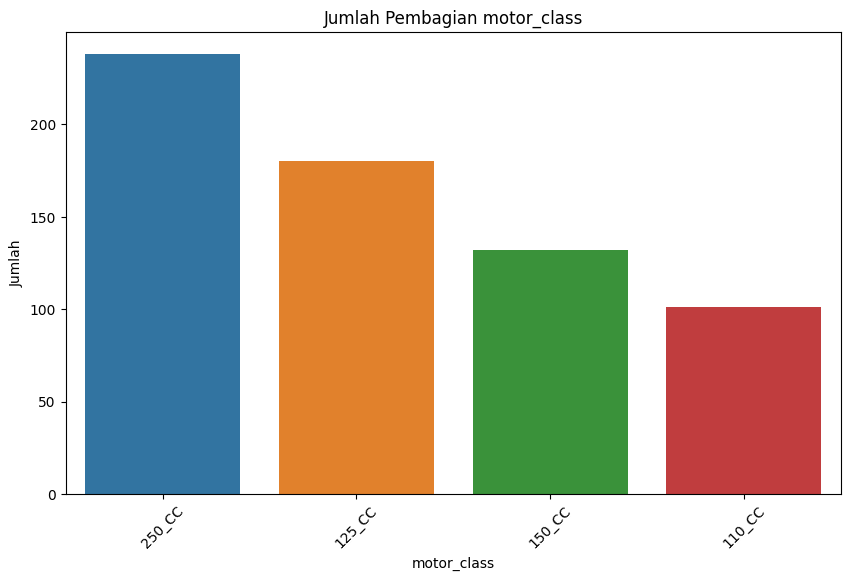

In [17]:
# Specify the string (categorical) column
column_name = 'motor_class'  # Replace with the actual column name

# Calculate value counts
value_counts = df[column_name].value_counts()

# Create a bar plot of the value counts
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title('Jumlah Pembagian ' + column_name)
plt.xlabel(column_name)
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.show()

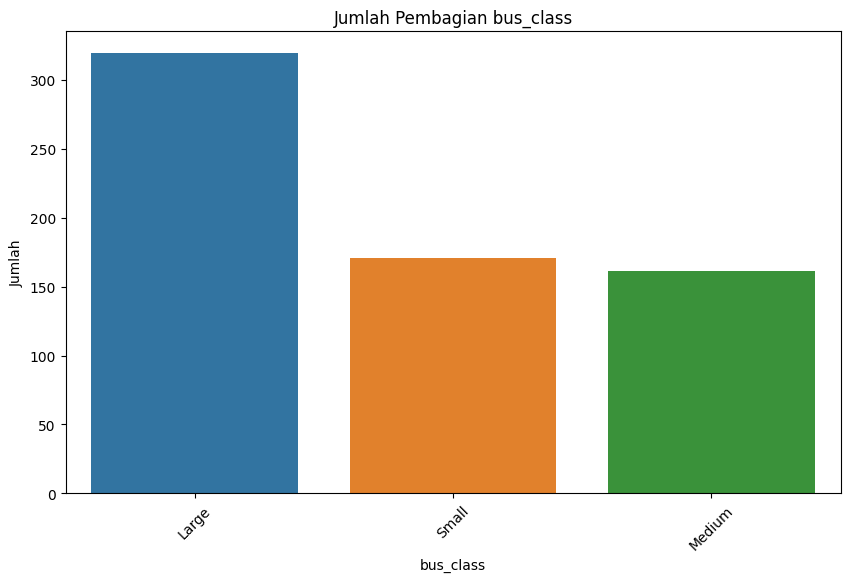

In [18]:
# Specify the string (categorical) column
column_name = 'bus_class'  # Replace with the actual column name

# Calculate value counts
value_counts = df[column_name].value_counts()

# Create a bar plot of the value counts
plt.figure(figsize=(10, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title('Jumlah Pembagian ' + column_name)
plt.xlabel(column_name)
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.show()

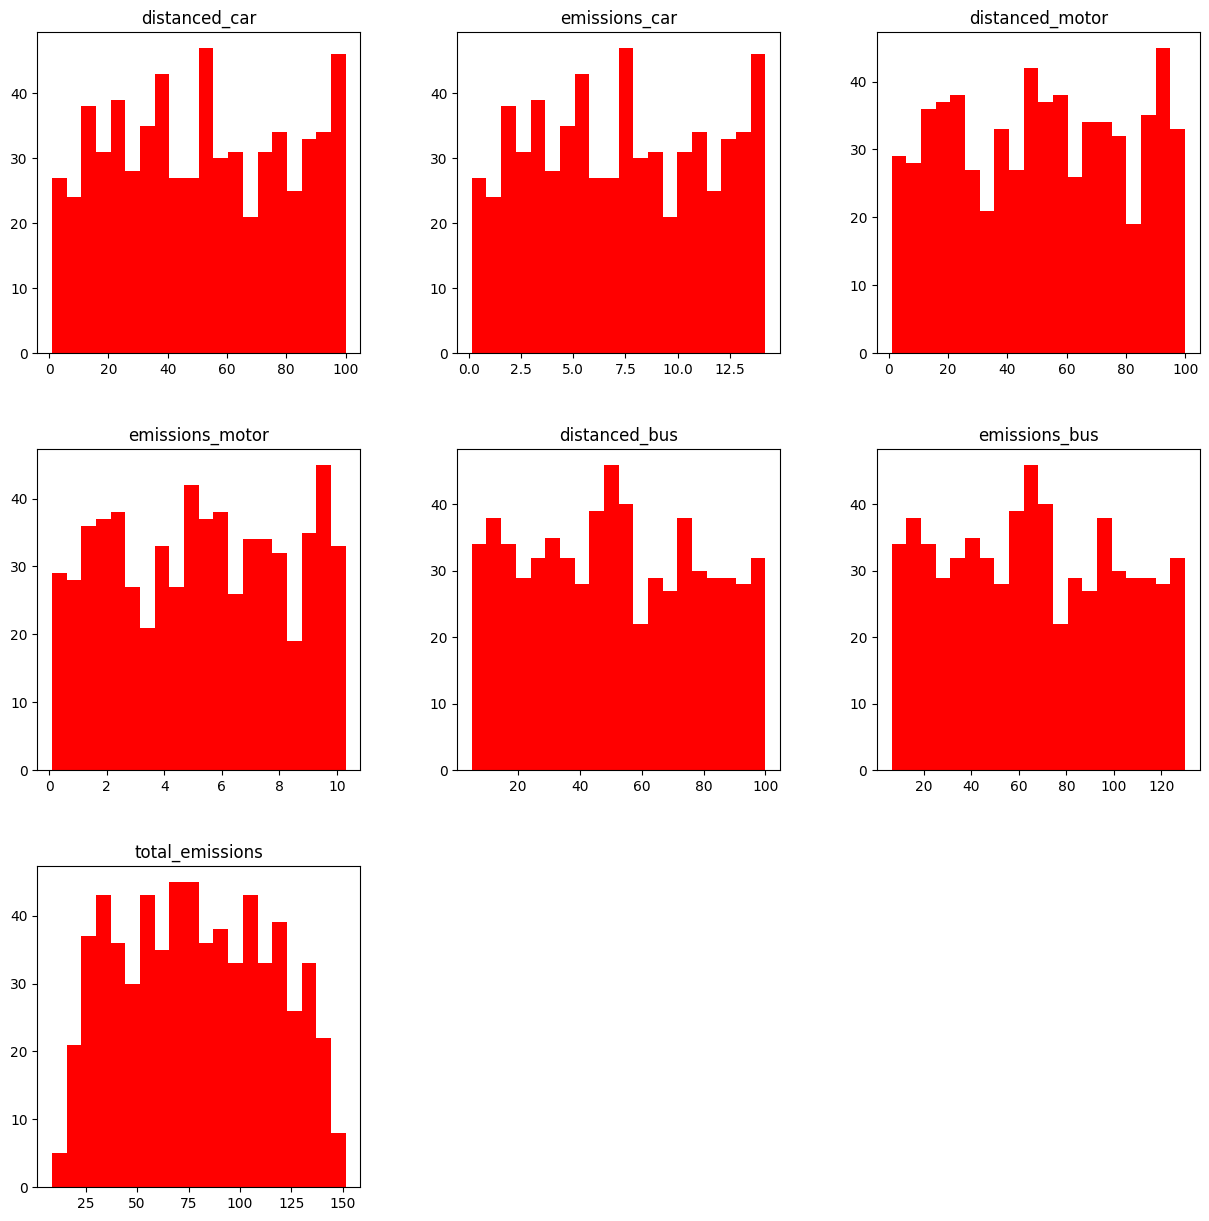

In [19]:
#Numeric
df.hist(bins = 20, figsize = (15, 15), color = "red", grid = False)
plt.show()

# Analisis Data

Pada tfep_kgco2e tidak terdapat user yang memiliki nilai 0 yang berarti seluruh responden melakukan konsumsi dari pilihan makanan sehingga seluruh responden menghasilkan emisi.
Pada makanan jagung terdapat 328 baris yang memiliki nilai 0, sedangkan pada makanan beras terdapat 18 baris yang memiliki nilai 0, pada makanan singkong terdapat 329 baris yang memiliki nilai 0, kemudian pada makanan kacang-kacangan terdapat 310 baris yang memiliki nilai 0, pada makanan daging unggas terdapat 322 baris yang memiliki nilai 0 dan terakhir pada makanan minyak kelapa sawit terdapat 333 baris yang memiliki nilai 0.

Seluruh baris tersebut tidak di drop karena responden bisa jadi tidak mengkonsumsi makanan tersebut pada hari tersebut.

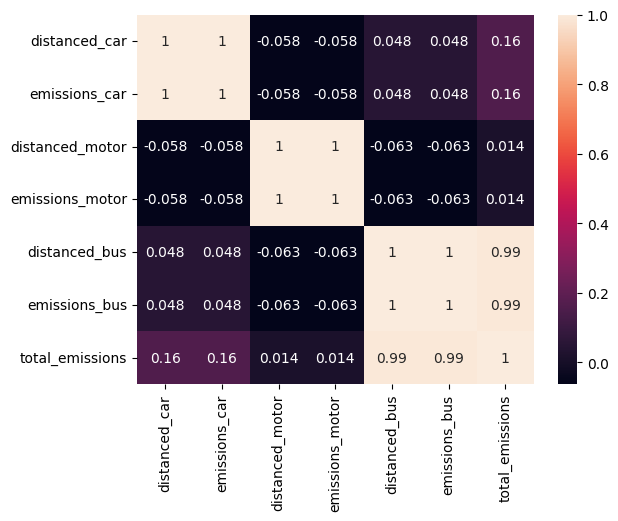

In [20]:
# Subset kolom emisi
emission_columns = ['distanced_car',	'emissions_car',	'distanced_motor',	'emissions_motor',	'distanced_bus',	'emissions_bus']

# Melihat korelasi antarkolom dengan kolom total_emissions
sns.heatmap(df[emission_columns + ['total_emissions']].corr(), annot=True)
plt.show()

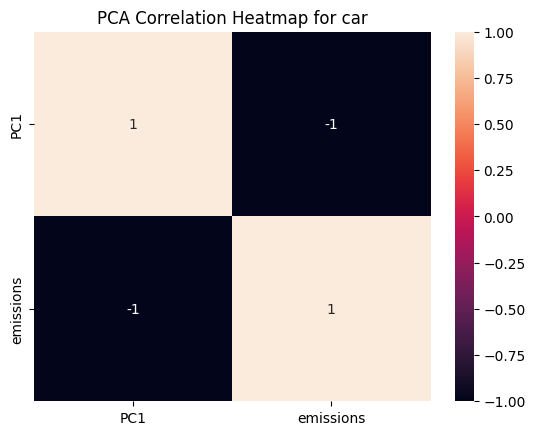

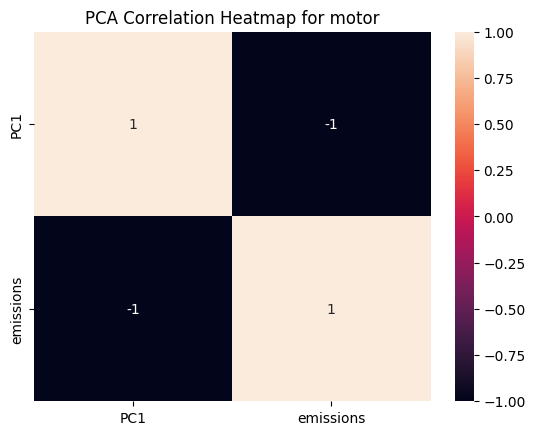

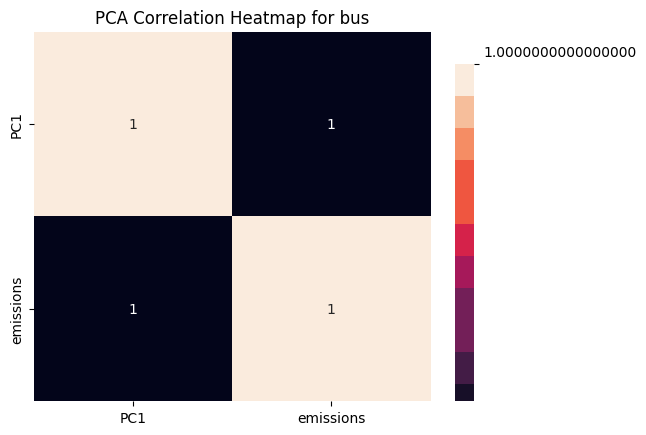

In [21]:
# Daftar vehicle yang ingin dianalisis
vehicle_list = ['car', 'motor', 'bus']

# Meloop melalui setiap kendaraan
for vehicle in vehicle_list:
    # Subset kolom fitur
    features = df[[f'distanced_{vehicle}']]

    # Menerapkan PCA pada fitur
    pca = PCA(n_components=1)
    transformed_features = pca.fit_transform(features)

    # Membuat DataFrame baru dari hasil PCA
    pca_df = pd.DataFrame(data=transformed_features, columns=['PC1'])

    # Menambahkan kolom target
    pca_df['emissions'] = df[f'emissions_{vehicle}']

    # Melihat korelasi antar kolom dengan heatmap
    sns.heatmap(pca_df.corr(), annot=True)
    plt.title(f'PCA Correlation Heatmap for {vehicle}')
    plt.show()

# Build Predict Model

## Car

Build the model to prediction emissions carbon to car

In [22]:
# Separate features and target for car
car_features = df[['distanced_car']]
car_target = df['emissions_car']

# Split the beras data into training and testing sets
car_X_train, car_X_test, car_y_train, car_y_test = train_test_split(car_features, car_target, test_size=0.2, random_state=42)

# Create a Sequential model for car
car_model = Sequential()
car_model.add(Dense(16, input_dim=car_X_train.shape[1], activation=None))
car_model.add(Dropout(0.2))
car_model.add(Dense(8, activation=None))
car_model.add(Dropout(0.2))
car_model.add(Dense(1, activation=None))

# Compile the model with MAE and MSE as metrics
car_model.compile(loss='mean_absolute_error', optimizer=Adam(), metrics=['mae', 'mse'])

# Create EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=5)

# Train the model with callbacks
history = car_model.fit(car_X_train, car_y_train, validation_data=(car_X_test, car_y_test), epochs=20, callbacks=[early_stopping])

# Evaluate the model
loss, mae, mse = car_model.evaluate(car_X_test, car_y_test)
car_y_pred = car_model.predict(car_X_test)

# Calculate R-squared
r_squared = r2_score(car_y_test, car_y_pred)

# Print the accuracy report and R-squared
print("Accuracy Report:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r_squared)

# Print the loss and validation loss
loss_val = history.history['loss']
val_loss = history.history['val_loss']
print("Loss:", loss_val)
print("Validation Loss:", val_loss)

Epoch 1/20
17/17 [==============================] - 4s 47ms/step - loss: 46.8372 - mae: 46.8372 - mse: 3631.1826 - val_loss: 36.7523 - val_mae: 36.7523 - val_mse: 1742.6578
Epoch 2/20
17/17 [==============================] - 0s 10ms/step - loss: 29.7337 - mae: 29.7337 - mse: 1658.3350 - val_loss: 18.7792 - val_mae: 18.7792 - val_mse: 457.4544
Epoch 3/20
17/17 [==============================] - 0s 12ms/step - loss: 18.2257 - mae: 18.2257 - mse: 701.0526 - val_loss: 3.1688 - val_mae: 3.1688 - val_mse: 13.6339
Epoch 4/20
17/17 [==============================] - 0s 14ms/step - loss: 15.5736 - mae: 15.5736 - mse: 481.2955 - val_loss: 2.0900 - val_mae: 2.0900 - val_mse: 5.1360
Epoch 5/20
17/17 [==============================] - 0s 13ms/step - loss: 14.3188 - mae: 14.3188 - mse: 395.7472 - val_loss: 1.1124 - val_mae: 1.1124 - val_mse: 1.7885
Epoch 6/20
17/17 [==============================] - 0s 13ms/step - loss: 13.5633 - mae: 13.5633 - mse: 373.7738 - val_loss: 0.9956 - val_mae: 0.9956 - va

Save our model

In [23]:
# Set the file paths for saving the models
h5_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/mobil/car_model.h5'
tflite_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/mobil/car_model.tflite'
json_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/mobil/car_model.json'
bin_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/mobil/car_model.bin'
tensorflow_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/mobil/car_model.tensorflow'
tensorflowjs_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/mobil/tfjs_model'

# Save model in h5 format
car_model.save(h5_model_path)

# Save model in TensorFlow SavedModel format
tf.saved_model.save(car_model, tensorflow_model_path)

# Save model in TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(car_model)
tflite_model = converter.convert()
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Save model in JSON format
model_json = car_model.to_json()
with open(json_model_path, 'w') as f:
    f.write(model_json)

# Save model weights in binary format
car_model.save_weights(bin_model_path)

# Save model in TensorFlow.js format
tfjs.converters.save_keras_model(car_model, tensorflowjs_model_path)

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Make Prediction to New Data

In [24]:
# Load the model that has been saved
car_model = load_model('/content/drive/MyDrive/Vehicle_Greenix/new_model/mobil/car_model.h5')

# Convert the string input to a float
distanced_car_new = float(input("Masukkan Jarak Tempuh: "))

# Create a DataFrame with the new data
car_data_baru = pd.DataFrame({'distanced_car': [distanced_car_new]})

# Perform the prediction using the model
prediksi_car = car_model.predict(car_data_baru)

# Print the result of the prediction
print("Hasil prediksi konsumsi Model:")
print(prediksi_car)

Masukkan Jarak Tempuh: 10
1/1 [==============================] - 0s 63ms/step
Hasil prediksi konsumsi Model:
[[1.504]]


## Sepeda Motor

Build the model to prediction emissions carbon to motorcyle

In [25]:
# Separate features and target for motor
motor_features = df[['distanced_motor']]
motor_target = df['emissions_motor']

# Split the beras data into training and testing sets
motor_X_train, motor_X_test, motor_y_train, motor_y_test = train_test_split(motor_features, motor_target, test_size=0.2, random_state=42)

# Create a Sequential model for motor
motor_model = Sequential()
motor_model.add(Dense(64, input_dim=car_X_train.shape[1], activation=None))
motor_model.add(Dropout(0.2))
motor_model.add(Dense(32, activation=None))
motor_model.add(Dropout(0.2))
motor_model.add(Dense(1, activation=None))

# Compile the model with MAE and MSE as metrics
motor_model.compile(loss='mean_absolute_error', optimizer=Adam(), metrics=['mae', 'mse'])

# Create EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=5)

# Train the model with callbacks
history = motor_model.fit(car_X_train, car_y_train, validation_data=(car_X_test, car_y_test), epochs=20, callbacks=[early_stopping])

# Evaluate the model
loss, mae, mse = motor_model.evaluate(motor_X_test, motor_y_test)
motor_y_pred = motor_model.predict(motor_X_test)

# Calculate R-squared
r_squared = r2_score(motor_y_test, motor_y_pred)

# Print the accuracy report and R-squared
print("Accuracy Report:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r_squared)

# Print the loss and validation loss
loss_val = history.history['loss']
val_loss = history.history['val_loss']
print("Loss:", loss_val)
print("Validation Loss:", val_loss)

Epoch 1/20
17/17 [==============================] - 1s 15ms/step - loss: 7.7210 - mae: 7.7210 - mse: 125.2789 - val_loss: 0.4047 - val_mae: 0.4047 - val_mse: 0.2175
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 6.5887 - mae: 6.5887 - mse: 86.8015 - val_loss: 0.9687 - val_mae: 0.9687 - val_mse: 1.2088
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 5.8458 - mae: 5.8458 - mse: 69.9564 - val_loss: 0.7431 - val_mae: 0.7431 - val_mse: 0.7260
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 4.4570 - mae: 4.4570 - mse: 42.3693 - val_loss: 0.2543 - val_mae: 0.2543 - val_mse: 0.0798
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 4.1546 - mae: 4.1546 - mse: 36.0631 - val_loss: 0.2733 - val_mae: 0.2733 - val_mse: 0.1007
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 3.8065 - mae: 3.8065 - mse: 29.5518 - val_loss: 0.6801 - val_mae: 0.6801 - val_mse: 0.5826
Epoch 7/20
17/17 [==

Save our model

In [26]:
# Set the file paths for saving the models
h5_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/motor/motor_model.h5'
tflite_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/motor/motor_model.tflite'
json_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/motor/motor_model.json'
bin_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/motor/motor_model.bin'
tensorflow_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/motor/motor_model.tensorflow'
tensorflowjs_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/motor/tfjs_model'

# Save model in h5 format
motor_model.save(h5_model_path)

# Save model in TensorFlow SavedModel format
tf.saved_model.save(motor_model, tensorflow_model_path)

# Save model in TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(motor_model)
tflite_model = converter.convert()
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Save model in JSON format
model_json = motor_model.to_json()
with open(json_model_path, 'w') as f:
    f.write(model_json)

# Save model weights in binary format
motor_model.save_weights(bin_model_path)

# Save model in TensorFlow.js format
tfjs.converters.save_keras_model(motor_model, tensorflowjs_model_path)

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Make Prediction to New Data

In [32]:
# Load the model that has been saved
motor_model = load_model('/content/drive/MyDrive/Vehicle_Greenix/new_model/motor/motor_model.h5')

# Convert the string input to a float
distanced_motor_new = float(input("Masukkan Jarak Tempuh: "))

# Create a DataFrame with the new data
motor_data_baru = pd.DataFrame({'distanced_motor': [distanced_motor_new]})

# Perform the prediction using the model
prediksi_motor = motor_model.predict(motor_data_baru)

# Print the result of the prediction
print("Hasil prediksi konsumsi Model:")
print(prediksi_motor)

Masukkan Jarak Tempuh: 10
1/1 [==============================] - 0s 64ms/step
Hasil prediksi konsumsi Model:
[[3.597]]


## Bus

Build the model to prediction emissions carbon to bus

In [28]:
# Separate features and target for bus
bus_features = df[['distanced_bus']]
bus_target = df['emissions_bus']

# Split the beras data into training and testing sets
bus_X_train, bus_X_test, bus_y_train, bus_y_test = train_test_split(bus_features, bus_target, test_size=0.2, random_state=42)

# Create a Sequential model for bus
bus_model = Sequential()
bus_model.add(Dense(64, input_dim=car_X_train.shape[1], activation=None))
bus_model.add(Dropout(0.2))
bus_model.add(Dense(32, activation=None))
bus_model.add(Dropout(0.2))
bus_model.add(Dense(1, activation=None))

# Compile the model with MAE and MSE as metrics
bus_model.compile(loss='mean_absolute_error', optimizer=Adam(), metrics=['mae', 'mse'])

# Create EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=5)

# Train the model with callbacks
history = motor_model.fit(bus_X_train, bus_y_train, validation_data=(bus_X_test, bus_y_test), epochs=20, callbacks=[early_stopping])

# Evaluate the model
loss, mae, mse = bus_model.evaluate(bus_X_test, bus_y_test)
bus_y_pred = bus_model.predict(bus_X_test)

# Calculate R-squared
r_squared = r2_score(bus_y_test, bus_y_pred)

# Print the accuracy report and R-squared
print("Accuracy Report:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r_squared)

# Print the loss and validation loss
loss_val = history.history['loss']
val_loss = history.history['val_loss']
print("Loss:", loss_val)
print("Validation Loss:", val_loss)

Epoch 1/20
17/17 [==============================] - 1s 16ms/step - loss: 45.2256 - mae: 45.2256 - mse: 2911.9285 - val_loss: 8.8120 - val_mae: 8.8120 - val_mse: 101.8981
Epoch 2/20
17/17 [==============================] - 0s 6ms/step - loss: 11.0720 - mae: 11.0720 - mse: 239.6505 - val_loss: 5.2567 - val_mae: 5.2567 - val_mse: 36.3354
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 8.2052 - mae: 8.2052 - mse: 138.0267 - val_loss: 1.6575 - val_mae: 1.6575 - val_mse: 3.4612
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 7.1472 - mae: 7.1472 - mse: 98.4280 - val_loss: 2.5107 - val_mae: 2.5107 - val_mse: 8.4134
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 7.2802 - mae: 7.2802 - mse: 104.2789 - val_loss: 3.5819 - val_mae: 3.5819 - val_mse: 17.0309
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 6.9521 - mae: 6.9521 - mse: 96.1077 - val_loss: 1.1607 - val_mae: 1.1607 - val_mse: 1.8621
Epoch 7/

5/5 [==============================] - 0s 3ms/step
Accuracy Report:
Mean Absolute Error (MAE): 79.47306060791016
Mean Squared Error (MSE): 8239.328125
R-squared: -5.35722637369601
Loss: [45.22556686401367, 11.072006225585938, 8.205169677734375, 7.147233486175537, 7.280165195465088, 6.952131271362305, 6.982889652252197, 6.983661651611328, 6.769845962524414, 6.624223709106445, 6.813811302185059, 6.280378818511963, 6.793612480163574, 6.44289493560791]
Validation Loss: [8.81203556060791, 5.25665283203125, 1.6575380563735962, 2.5107007026672363, 3.581932544708252, 1.1607410907745361, 1.0630391836166382, 2.1707820892333984, 0.12921202182769775, 0.7795279026031494, 1.7612977027893066, 4.178731918334961, 0.5101750493049622, 0.43233737349510193]


Save our model

In [30]:
# Set the file paths for saving the models
h5_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/motor/motor_model.h5'
tflite_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/motor/motor_model.tflite'
json_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/motor/motor_model.json'
bin_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/motor/motor_model.bin'
tensorflow_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/motor/motor_model.tensorflow'
tensorflowjs_model_path = '/content/drive/MyDrive/Vehicle_Greenix/new_model/motor/tfjs_model'

# Save model in h5 format
bus_model.save(h5_model_path)

# Save model in TensorFlow SavedModel format
tf.saved_model.save(bus_model, tensorflow_model_path)

# Save model in TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(bus_model)
tflite_model = converter.convert()
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Save model in JSON format
model_json = motor_model.to_json()
with open(json_model_path, 'w') as f:
    f.write(model_json)

# Save model weights in binary format
bus_model.save_weights(bin_model_path)

# Save model in TensorFlow.js format
tfjs.converters.save_keras_model(bus_model, tensorflowjs_model_path)

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Make Prediction to New Data

In [31]:
# Load the model that has been saved
bus_model = load_model('/content/drive/MyDrive/Vehicle_Greenix/new_model/bus/bus_model.h5')

# Convert the string input to a float
distanced_bus_new = float(input("Masukkan Jarak Tempuh: "))

# Create a DataFrame with the new data
bus_data_baru = pd.DataFrame({'distanced_bus': [distanced_bus_new]})

# Perform the prediction using the model
prediksi_bus = bus_model.predict(bus_data_baru)

# Print the result of the prediction
print("Hasil prediksi Emisi Bus:")
print(prediksi_motor)

Masukkan Jarak Tempuh: 10


1/1 [==============================] - 0s 72ms/step
Hasil prediksi Emisi Bus:
[[1.29]]
